In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
rooth_path = 'data/'
deng_sj_train = pd.read_csv(rooth_path + 'deng_sj_train.csv')
deng_iq_train = pd.read_csv(rooth_path + 'deng_iq_train.csv')
deng_sj_val = pd.read_csv(rooth_path + 'deng_sj_val.csv')
deng_iq_val = pd.read_csv(rooth_path + 'deng_iq_val.csv')
test_sj = pd.read_csv(rooth_path + 'test_sj_.csv')
test_iq = pd.read_csv(rooth_path + 'test_iq_.csv')

In [3]:
def pred_regressor(model, regressor, X_train, X_val, y_train, y_val, params):  
    
    #Grid Search
    grid_search = GridSearchCV(estimator=regressor, param_grid=params, cv=5, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_val)
    
    #Predictions
    predictions = {'y_pred' : y_pred}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    print ("Test  MAE error :", mean_absolute_error(y_pred, y_val))
    
    return grid_search.best_estimator_, df_predictions

In [4]:
# Random Forest Regressor
def rfr(X_train, X_val, y_train, y_val):
    
    model = 'Random Forest Regressor'
    regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
    gs_params = {'n_estimators': [90,100,200,300], 'criterion': ['mae'], 'max_features': ['sqrt', 'auto', 'log2'],
                'min_samples_split' : [7,8,9,10,12,13], 'max_depth': [2,3,4,5]}

    regressor_rfr, pred_rfr = pred_regressor(model, regressor, X_train, X_val, y_train, y_val, params=gs_params)
    
    print('\nBest Parameters:\n',regressor_rfr)
    
    return regressor_rfr, pred_rfr

In [5]:
# Gradient Boosting Regressor
def gbr(X_train, X_val, y_train, y_val):
    
    model = 'Gradient Boosting Regressor'
    regressor = GradientBoostingRegressor(random_state=42)
    gs_params = {'learning_rate': [0.01, 0.1, 0.5, 1], 'n_estimators': [100, 200, 250, 300], 'criterion': ['mae'],
                 'max_features': ['sqrt', 'auto', 'log2'], 'min_samples_split' : [7,8,10,12], 'max_depth': [3,5,7,10]}

    regressor_gbr, pred_gbr = pred_regressor(model, regressor, X_train, X_val, y_train, y_val, params=gs_params)
    
    print('\nBest Parameters:\n',regressor_gbr)
    
    return regressor_gbr, pred_gbr

In [6]:
# Decision Tree
def dtr(X_train, X_val, y_train, y_val):
    
    model = 'Decision Tree Regressor'
    regressor = DecisionTreeRegressor(random_state=42)
    gs_params = { 'criterion': ['mae'], 'max_features': ['sqrt', 'auto', 'log2'], 'min_samples_split' : [7,8,10,12], 
                 'max_depth': [3,5,7,10]}

    regressor_dtr, pred_dtr = pred_regressor(model, regressor, X_train, X_val, y_train, y_val, params=gs_params)
    
    print('\nBest Parameters:\n',regressor_dtr)
    
    return regressor_dtr, pred_dtr

In [7]:
def xgb(X_train, X_val, y_train, y_val):
    
    model = XGBRegressor(
    max_depth=10,
    n_estimator=500,
    eta=0.3,
    subsample=0.9,
    alpha=0.8,
    min_child_weight=1,
    reg_lambda=1.8)

    model.fit(
    X_train, 
    y_train, 
    eval_metric = 'mae', 
    eval_set=[(X_train, y_train), (X_val, y_val)])
    
    y_pred = model.predict(X_val)
    
    #Predictions
    predictions = {'y_pred' : y_pred}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    print ("Test  MAE error :", mean_absolute_error(y_pred, y_val))
    
    return model, df_predictions

In [65]:
def plot_errors(predictions, val):
    plt.figure(figsize=(15,7))
    plt.plot(predictions, label='Predictions')
    plt.plot(val, label='Validation')
    plt.legend()
    plt.show()

### San Juan

In [26]:
X_train_sj = deng_sj_train.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_train_sj = deng_sj_train['total_cases']
X_val_sj = deng_sj_val.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_val_sj = deng_sj_val['total_cases']
X_test_sj = test_sj.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear'])

In [9]:
regressor_rfr_sj, pred_rfr_sj = rfr(X_train_sj, X_val_sj, y_train_sj, y_val_sj)

Test  MAE error : 19.540967741935482

Best Parameters:
 RandomForestRegressor(criterion='mae', max_depth=3, min_samples_split=13,
                      n_jobs=-1, random_state=42)


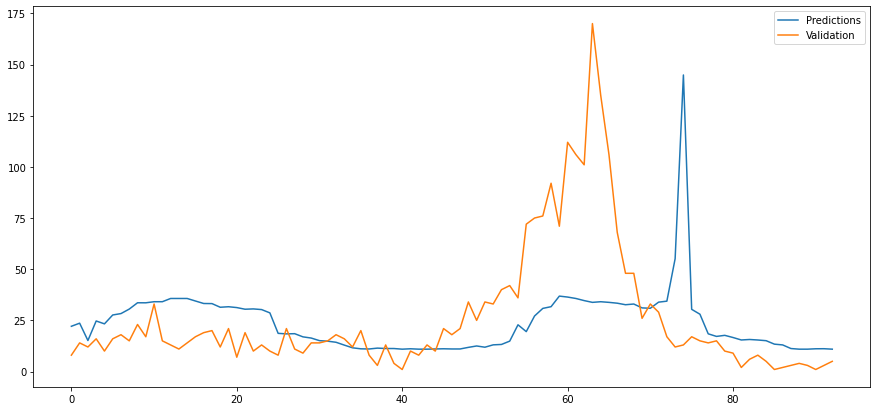

In [66]:
plot_errors(pred_rfr_sj, y_val_sj)

In [10]:
regressor_gbr_sj, pred_gbr_sj = gbr(X_train_sj, X_val_sj, y_train_sj, y_val_sj)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)


Test  MAE error : 17.519998876637057

Best Parameters:
 GradientBoostingRegressor(criterion='mae', learning_rate=0.01,
                          max_features='log2', min_samples_split=7,
                          n_estimators=300, random_state=42)


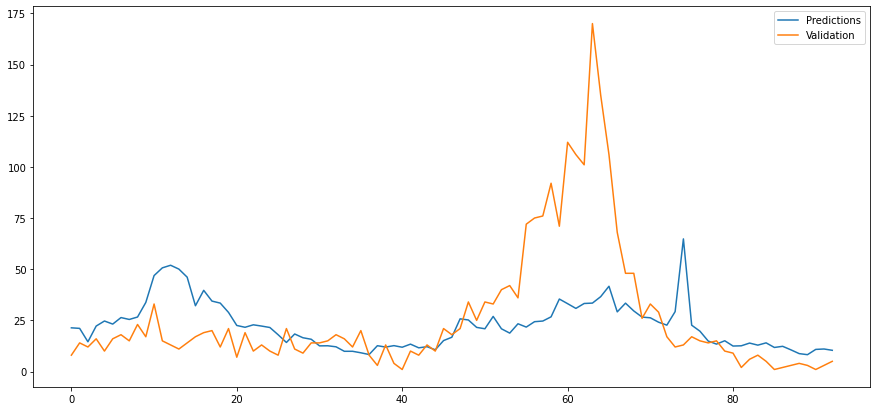

In [67]:
plot_errors(pred_gbr_sj, y_val_sj)

In [11]:
regressor_dtr_sj, pred_dtr_sj = dtr(X_train_sj, X_val_sj, y_train_sj, y_val_sj)

Test  MAE error : 18.666666666666668

Best Parameters:
 DecisionTreeRegressor(criterion='mae', max_depth=3, max_features='auto',
                      min_samples_split=7, random_state=42)


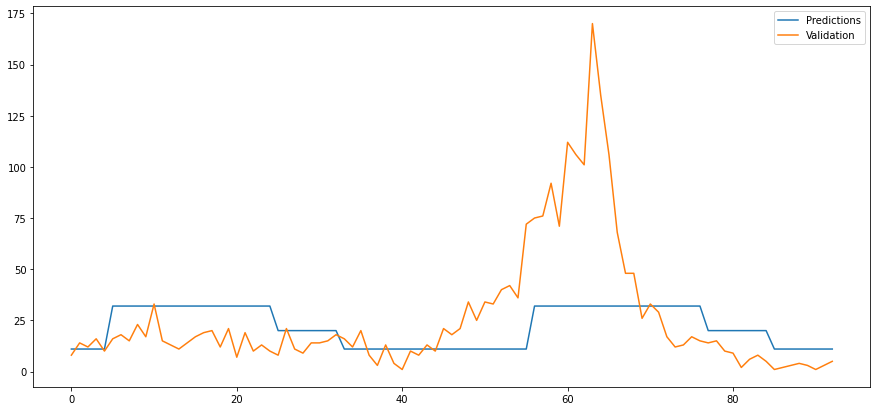

In [68]:
plot_errors(pred_dtr_sj, y_val_sj)

In [12]:
model_xgb_sj, pred_xgb_sj = xgb(X_train_sj, X_val_sj, y_train_sj, y_val_sj)

[03:55:19] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mae:26.21758	validation_1-mae:22.71752
[1]	validation_0-mae:19.94188	validation_1-mae:22.23307
[2]	validation_0-mae:15.29823	validation_1-mae:22.10429
[3]	validation_0-mae:11.87954	validation_1-mae:21.34064
[4]	validation_0-mae:9.35481	validation_1-mae:21.07385
[5]	validation_0-mae:7.51223	validation_1-mae:20.51683
[6]	validation_0-mae:6.19369	validation_1-mae:20.66699
[7]	validation_0-mae:5.06008	validation_1-mae:20.91685
[8]	validation_0-mae:4.14763	validation_1-mae:20.99574
[9]	validation_0-mae:3.49502	validation_1-mae:20.91236
[10]	validation_0-mae:2.95296	validation_1-mae:20.90351
[11]	validation_0-mae:2.56189	validation_1-mae:20.70640
[12

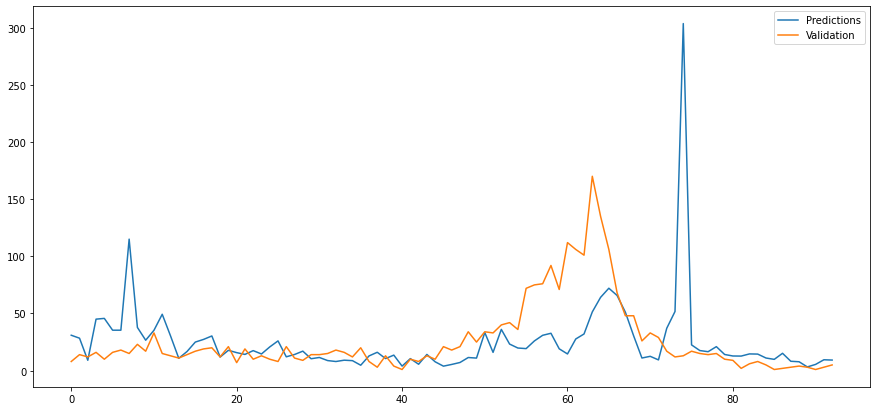

In [69]:
plot_errors(pred_xgb_sj, y_val_sj)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

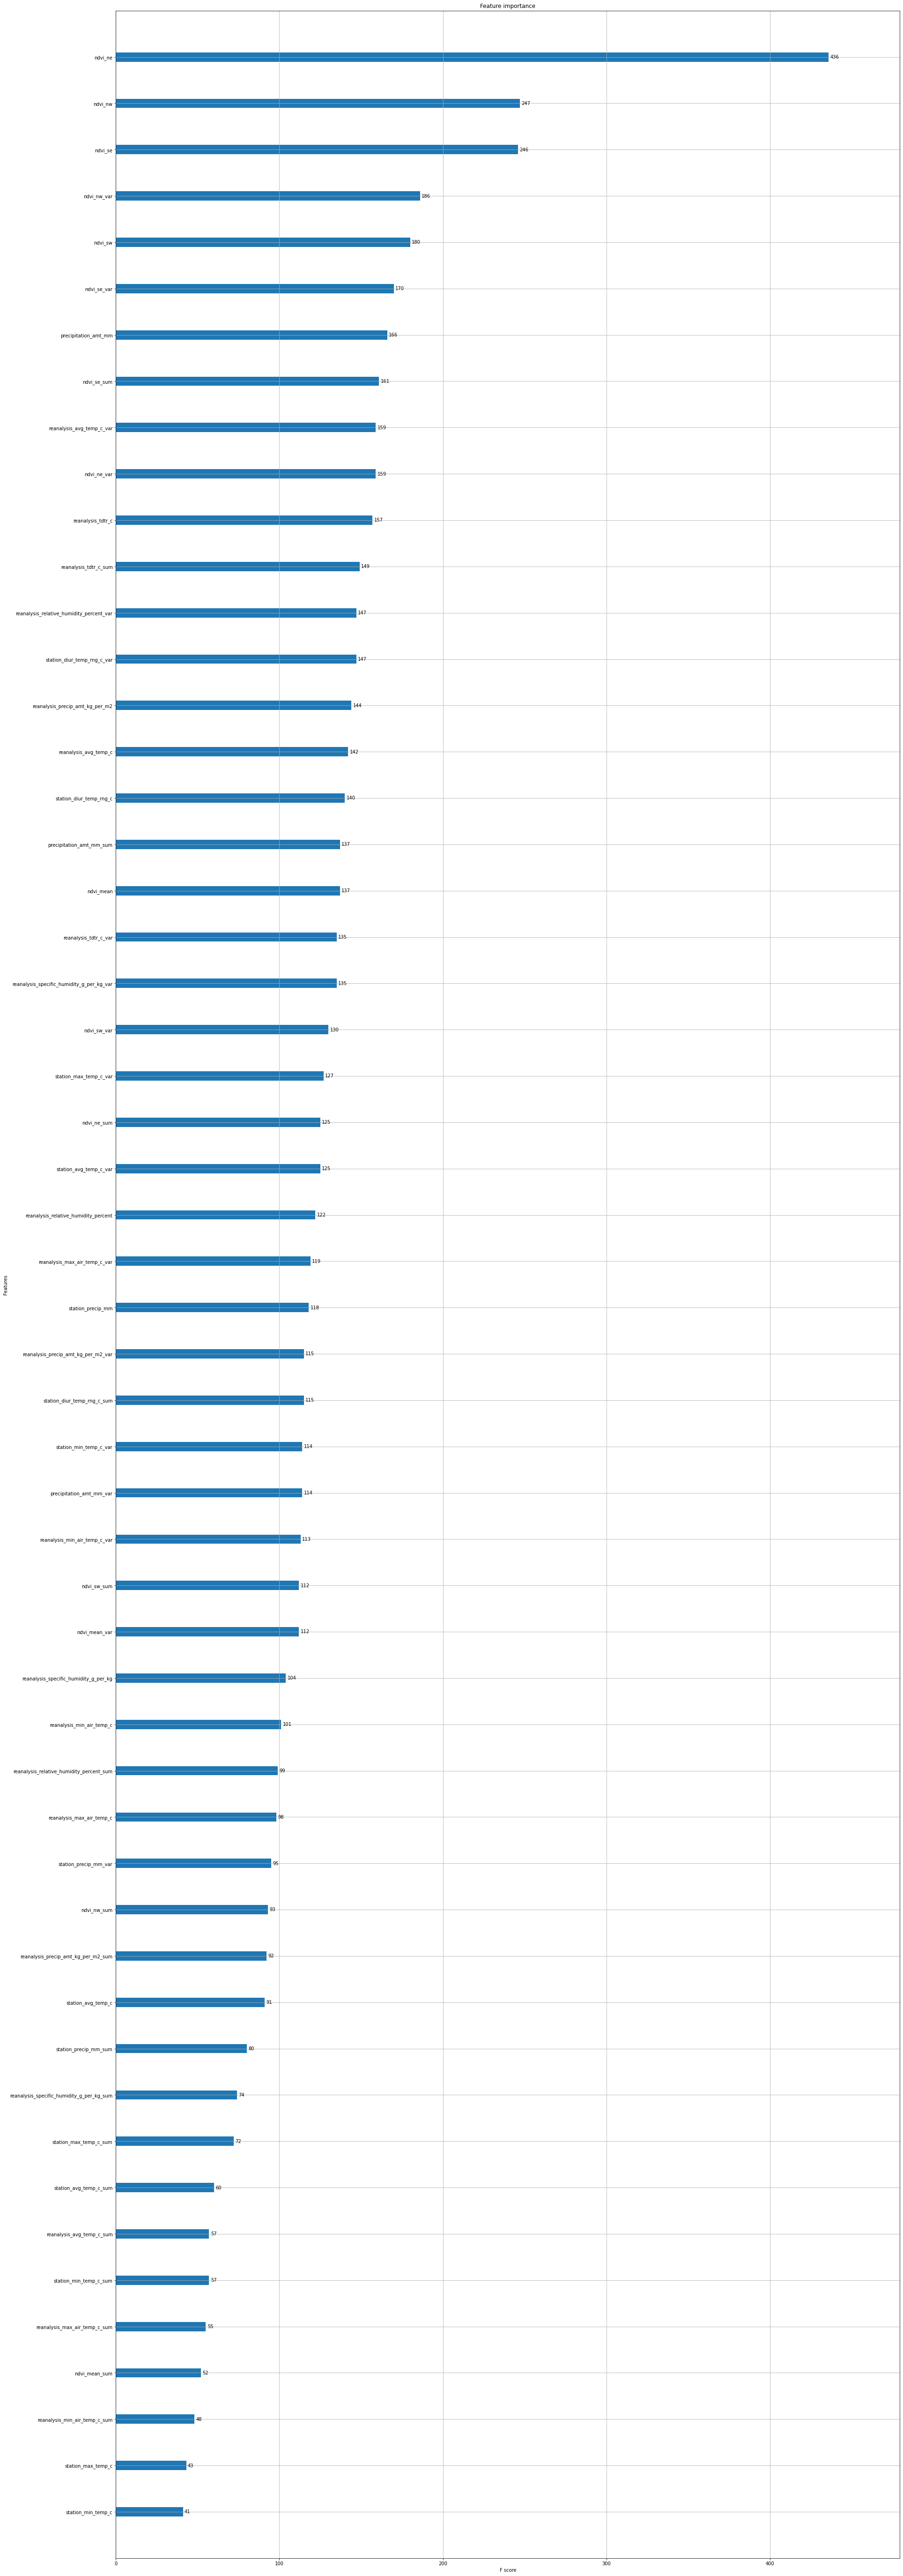

In [23]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model_xgb_sj, (30,100))

### Iquitos

In [27]:
X_train_iq = deng_iq_train.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_train_iq = deng_iq_train['total_cases']
X_val_iq = deng_iq_val.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_val_iq = deng_iq_val['total_cases']
X_test_iq = test_iq.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear'])

In [14]:
regressor_rfr_iq, pred_rfr_iq = rfr(X_train_iq, X_val_iq, y_train_iq, y_val_iq)

Test  MAE error : 3.646057692307692

Best Parameters:
 RandomForestRegressor(criterion='mae', max_depth=2, max_features='log2',
                      min_samples_split=7, n_estimators=200, n_jobs=-1,
                      random_state=42)


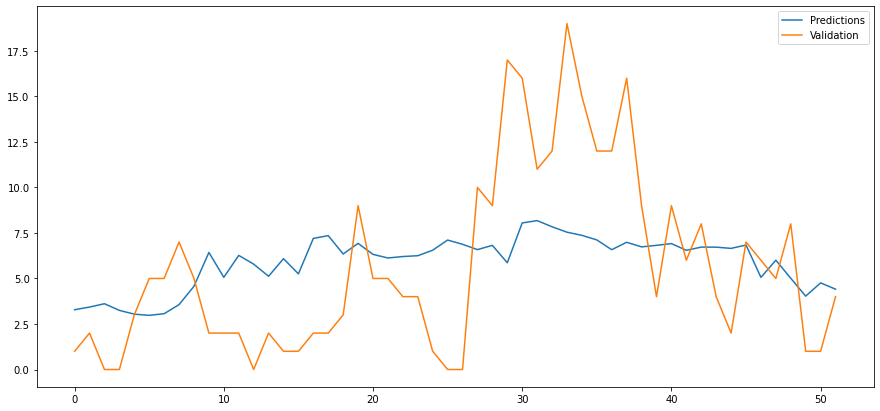

In [70]:
plot_errors(pred_rfr_iq, y_val_iq)

In [15]:
regressor_gbr_iq, pred_gbr_iq = gbr(X_train_iq, X_val_iq, y_train_iq, y_val_iq)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1633: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  " loss='lad' instead.", FutureWarning)


Test  MAE error : 4.264520155203656

Best Parameters:
 GradientBoostingRegressor(criterion='mae', learning_rate=0.01,
                          max_features='log2', min_samples_split=7,
                          random_state=42)


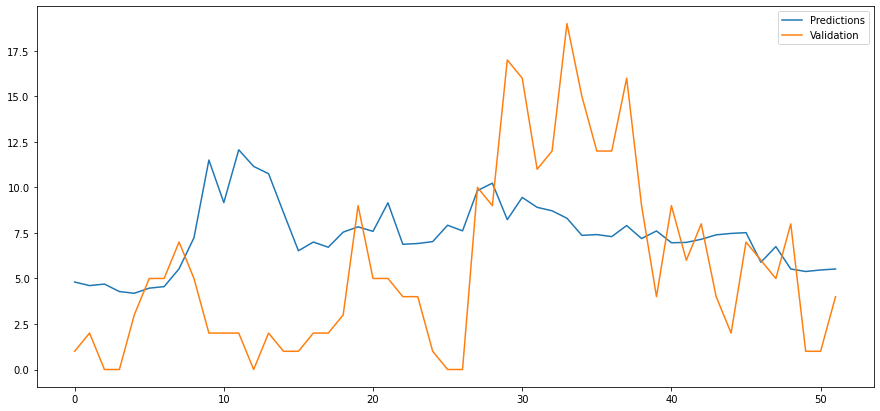

In [71]:
plot_errors(pred_gbr_iq, y_val_iq)

In [16]:
regressor_dtr_iq, pred_dtr_iq = dtr(X_train_iq, X_val_iq, y_train_iq, y_val_iq)

Test  MAE error : 5.115384615384615

Best Parameters:
 DecisionTreeRegressor(criterion='mae', max_depth=3, max_features='sqrt',
                      min_samples_split=7, random_state=42)


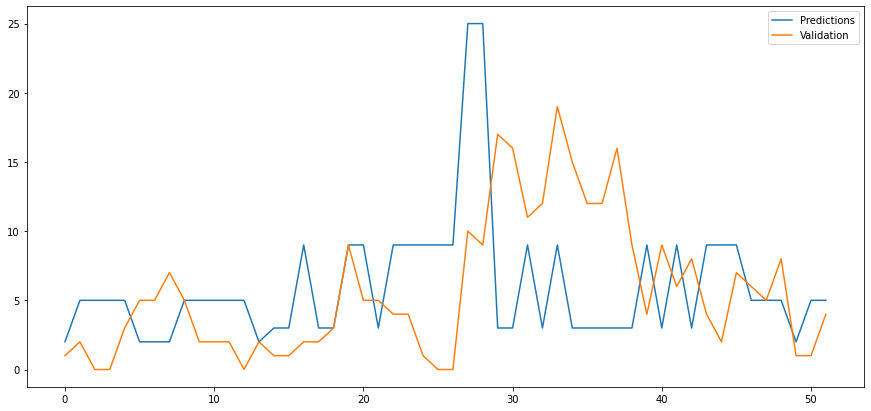

In [72]:
plot_errors(pred_dtr_iq, y_val_iq)

In [17]:
model_xgb_iq, pred_xgb_iq = xgb(X_train_iq, X_val_iq, y_train_iq, y_val_iq)

[07:43:27] WARNING: ../src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mae:5.88714	validation_1-mae:4.72669
[1]	validation_0-mae:4.67986	validation_1-mae:4.79007
[2]	validation_0-mae:3.74505	validation_1-mae:5.98331
[3]	validation_0-mae:2.95955	validation_1-mae:6.07792
[4]	validation_0-mae:2.41286	validation_1-mae:6.11174
[5]	validation_0-mae:1.95132	validation_1-mae:6.42386
[6]	validation_0-mae:1.62484	validation_1-mae:6.68269
[7]	validation_0-mae:1.36775	validation_1-mae:6.85830
[8]	validation_0-mae:1.14367	validation_1-mae:6.92506
[9]	validation_0-mae:0.97716	validation_1-mae:6.98097
[10]	validation_0-mae:0.84720	validation_1-mae:7.07910
[11]	validation_0-mae:0.75679	validation_1-mae:7.06183
[12]	validation_0-m

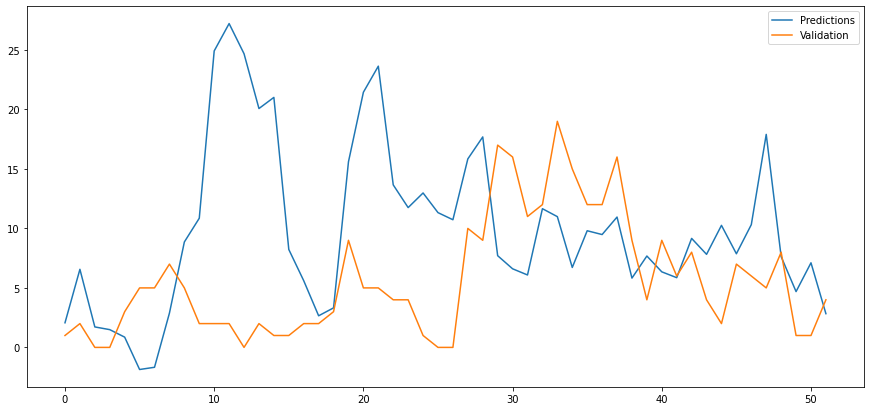

In [73]:
plot_errors(pred_xgb_iq, y_val_iq)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

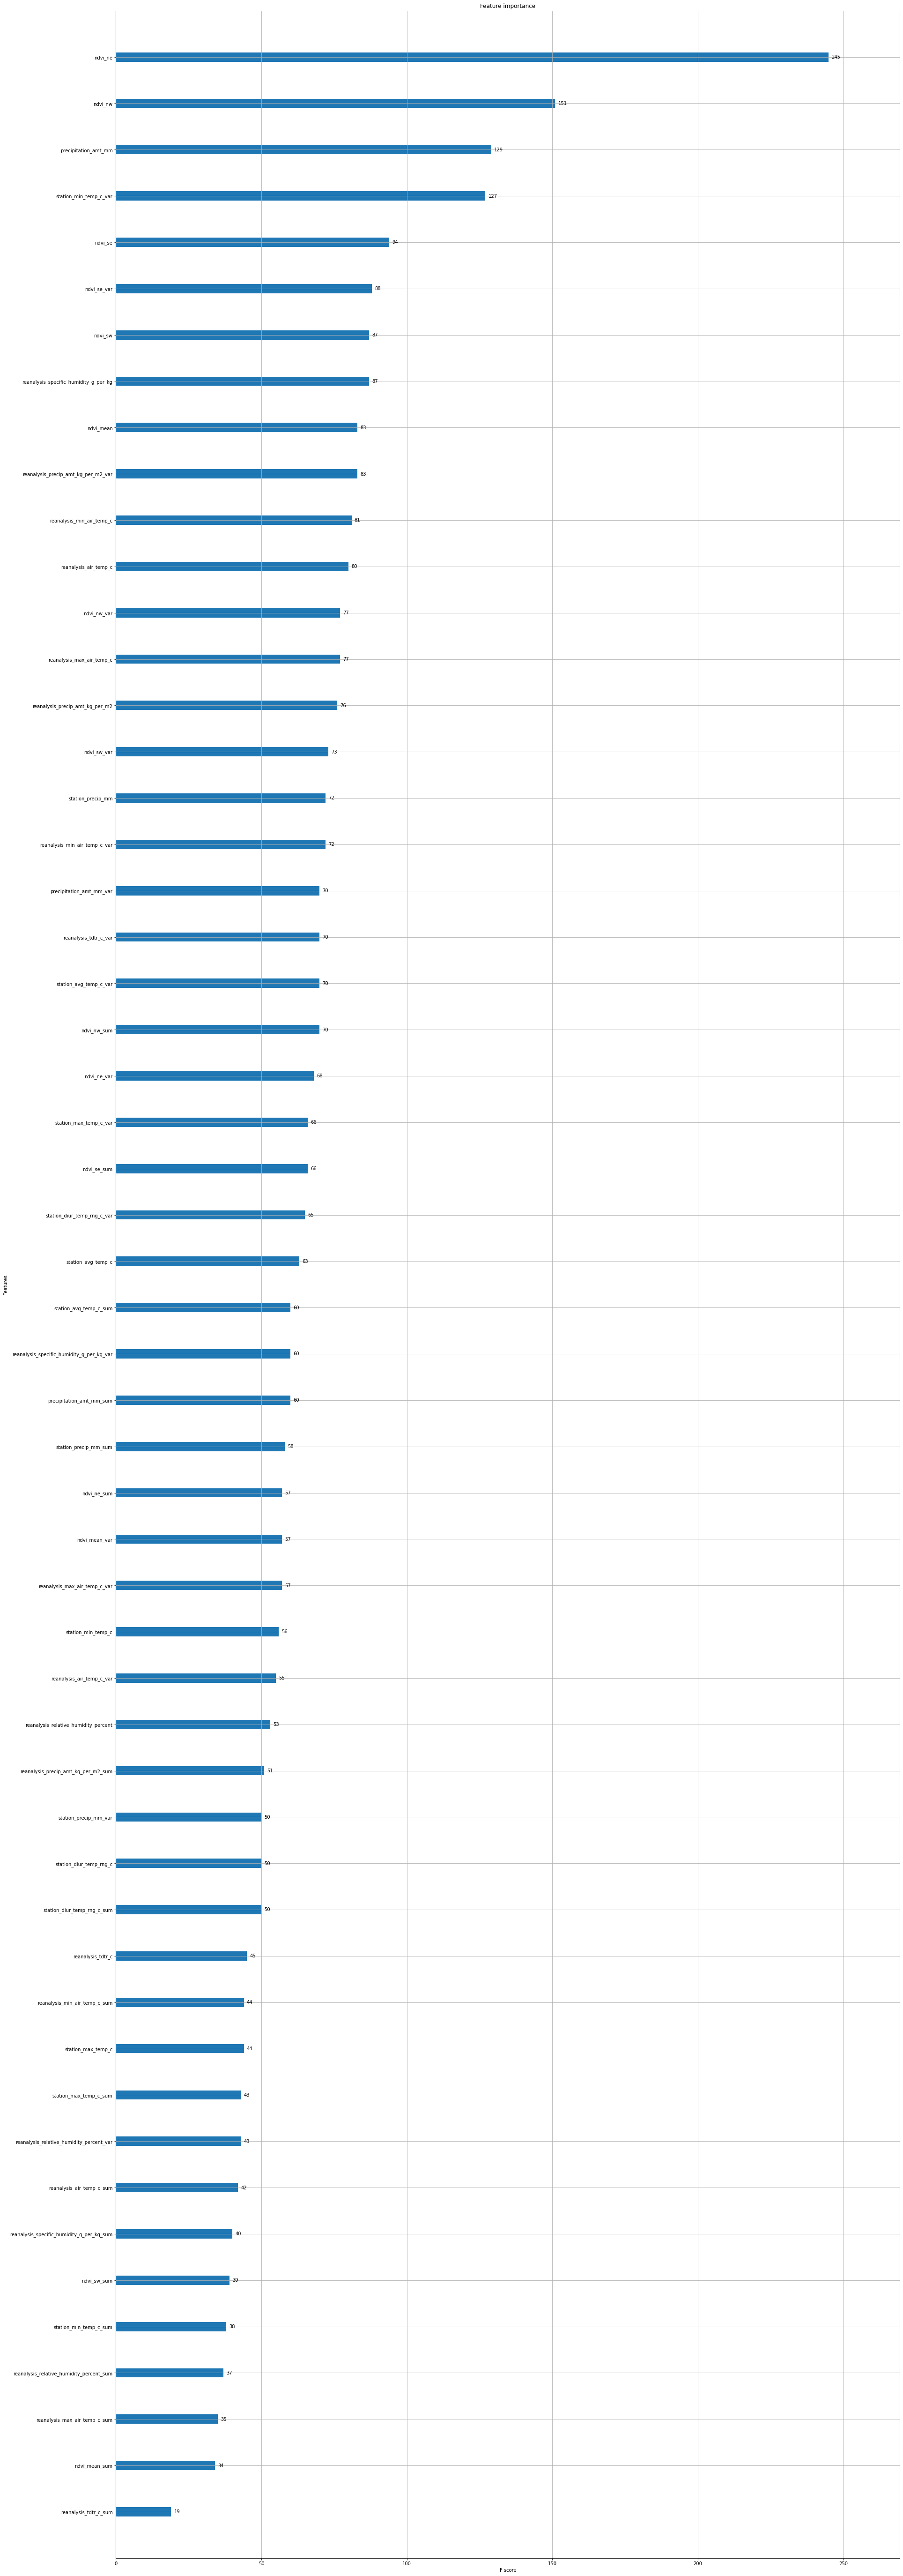

In [21]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model_xgb_iq, (30,100))

### First Submission

In [75]:
def submission(model_sj, model_iq, X_test_sj, X_test_iq, test_iq):
    
    total_cases_sj = model_sj.predict(X_test_sj).astype(int)
    total_cases_iq = model_iq.predict(X_test_iq).astype(int)
    
    submission_sj = test_sj[['city', 'year', 'weekofyear']]
    submission_sj['total_cases'] = total_cases_sj
    submission_iq = test_iq[['city', 'year', 'weekofyear']]
    submission_iq['total_cases'] = total_cases_iq
    
    submission_final = pd.concat([submission_sj, submission_iq], axis=0)
    
    return submission_final

In [83]:
submission_1 = submission(regressor_gbr_sj, regressor_rfr_iq, X_test_sj, X_test_iq, test_iq)
submission_1.to_csv('data/submission_1.csv', index=False)